In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from tensorflow.keras import layers
from IPython.display import FileLink

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print("Количество доступных GPU процессоров: ", len(tf.config.list_physical_devices('GPU')))

Количество доступных GPU процессоров:  1


In [3]:
%%time
df = np.load('/kaggle/input/sochi-data/pars_smp_train.npy')
df

CPU times: user 10.3 ms, sys: 3.62 s, total: 3.63 s
Wall time: 33.9 s


array([[[ 1.14232967,  0.8743082 ,  1.44608981],
        [-0.48404038,  0.61936718,  1.1793994 ],
        [ 0.66575019,  0.67293175,  1.14851425],
        ...,
        [-0.75664941,  0.62169112,  1.24812897],
        [ 1.66556441,  0.92514013,  1.53965631],
        [ 2.24337735,  1.16610985,  2.09913783]],

       [[ 4.85903742,  3.23126495,  2.90209578],
        [-7.29039441, -5.05621154,  1.33229062],
        [ 3.07779613, -2.77816895,  0.64732039],
        ...,
        [-2.97624653, -4.75995558, -2.38069386],
        [ 2.93048549,  0.83819116, -1.7839154 ],
        [-0.620153  ,  2.48687114, -0.96242668]],

       [[ 0.97876809,  0.67655572,  1.73955113],
        [ 0.28849528,  1.27203121,  2.02185647],
        [ 0.91805251,  0.99326457,  1.85336361],
        ...,
        [-0.47733673,  1.3408008 ,  1.86770453],
        [ 2.14300845,  0.21454462,  1.14332202],
        [ 0.12191956,  1.22080014,  1.69981002]],

       ...,

       [[-1.37911689, -0.07341832,  0.19586597],
        [ 2

np.save('train_300', data)

In [4]:
df.shape

(1000000, 200, 3)

In [4]:
target = np.load('/kaggle/input/sochi-light-data/y_smp_train.npy')
target

array([[[0.75344854],
        [1.25486516],
        [0.48308029],
        ...,
        [0.05710694],
        [0.10489978],
        [0.05500543]],

       [[1.40143573],
        [1.46708164],
        [0.41004429],
        ...,
        [0.06217801],
        [0.06687216],
        [0.07525195]],

       [[1.33440339],
        [2.33645351],
        [0.4617866 ],
        ...,
        [0.05637844],
        [0.06665131],
        [0.08015607]],

       ...,

       [[1.33873672],
        [2.80821415],
        [0.18490291],
        ...,
        [0.08322807],
        [0.07328545],
        [0.28525011]],

       [[1.02595641],
        [1.92272469],
        [0.44979392],
        ...,
        [0.09853619],
        [0.07069989],
        [0.0538653 ]],

       [[2.06270513],
        [1.23017213],
        [0.38630803],
        ...,
        [0.05311684],
        [0.06605585],
        [0.09807851]]])

In [6]:
target.shape

(1000000, 15, 1)

In [5]:
class PositionalEncoding(layers.Layer):
    def __init__(self):
        super(PositionalEncoding, self).__init__()

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / tf.pow(10000.00, tf.cast(2 * (i // 2), tf.float32) / tf.cast(d_model, tf.float32))
        return tf.cast(pos, tf.float32) * angle_rates

    def call(self, inputs):
        seq_length = tf.shape(inputs)[1]
        d_model = tf.shape(inputs)[2]
        pos = tf.range(seq_length)[:, tf.newaxis]
        i = tf.range(d_model)[tf.newaxis, :]
        angles = self.get_angles(pos, i, d_model)
        angles = tf.reshape(angles, shape=(seq_length, d_model))

        angles = tf.where(tf.math.equal(i % 2, 0), tf.sin(angles), tf.cos(angles))
        pos_encoding = angles[tf.newaxis, ...]

        return inputs + pos_encoding


In [7]:
target = np.squeeze(target)
target.shape

(1000000, 15)

In [8]:
def transformer_block(input_layer, num_heads, num_n, input_dim):
    # Слой мульти внимания(Multi-head attention)
    mha_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=input_dim)(input_layer, input_layer)
    mha_output = layers.LayerNormalization(epsilon=1e-6)(mha_output + input_layer)
    
    # Добавление скрытого слоя
    hidden_output = layers.Dense(1024, activation=layers.LeakyReLU(alpha=0.2))(mha_output)
    hidden_output = layers.Dropout(0.1)(hidden_output) 

    # Слои прямой неронной сети(Feed-forward network)
    ffn_output = layers.Dense(num_n, activation=layers.LeakyReLU(alpha=0.2))(mha_output)
    ffn_output = layers.Dense(input_dim)(ffn_output)
    return layers.LayerNormalization(epsilon=1e-6)(ffn_output + mha_output)

# Входящий слой(Input layer)
input = layers.Input(shape=(200, 3))

# Positional encoding + Transformer
X = PositionalEncoding()(input) 
X = transformer_block(X, num_heads=8, num_n=512, input_dim=3)

# Flatten and final dense layer 
X = layers.GlobalAveragePooling1D()(X)
output = layers.Dense(15, activation=layers.LeakyReLU(alpha=0.2))(X)


model = tf.keras.Model(inputs=input, outputs=output)
model.compile(optimizer='adam', loss='mse') 




In [9]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
callback = keras.callbacks.LearningRateScheduler(scheduler)
callback_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [11]:
%%time
hist = model.fit(df, target, validation_split=0.2, 
                 epochs=30, batch_size=1000, callbacks=[callback, callback_stop])

Epoch 1/30
850/850 [==============================] - 111s 131ms/step - loss: 0.1430 - val_loss: 0.1020 - lr: 0.0010
Epoch 2/30
850/850 [==============================] - 107s 126ms/step - loss: 0.0985 - val_loss: 0.0938 - lr: 0.0010
Epoch 3/30
850/850 [==============================] - 110s 130ms/step - loss: 0.0894 - val_loss: 0.0850 - lr: 0.0010
Epoch 4/30
850/850 [==============================] - 106s 125ms/step - loss: 0.0834 - val_loss: 0.0821 - lr: 0.0010
Epoch 5/30
850/850 [==============================] - 106s 125ms/step - loss: 0.0816 - val_loss: 0.0810 - lr: 0.0010
Epoch 6/30
850/850 [==============================] - 106s 125ms/step - loss: 0.0808 - val_loss: 0.0807 - lr: 0.0010
Epoch 7/30
850/850 [==============================] - 110s 129ms/step - loss: 0.0801 - val_loss: 0.0797 - lr: 0.0010
Epoch 8/30
850/850 [==============================] - 110s 129ms/step - loss: 0.0797 - val_loss: 0.0793 - lr: 0.0010
Epoch 9/30
850/850 [==============================] - 107s 125ms

In [15]:
df_hist = pd.DataFrame(hist.history)
display(df_hist.head())

,loss,val_loss,lr
0,0.207695,0.102236,0.001
1,0.101709,0.100620,0.001
2,0.098405,0.096142,0.001
3,0.094682,0.093191,0.001
4,0.092507,0.091845,0.001


In [16]:
print(df_hist.loss.min())

0.07844281196594238


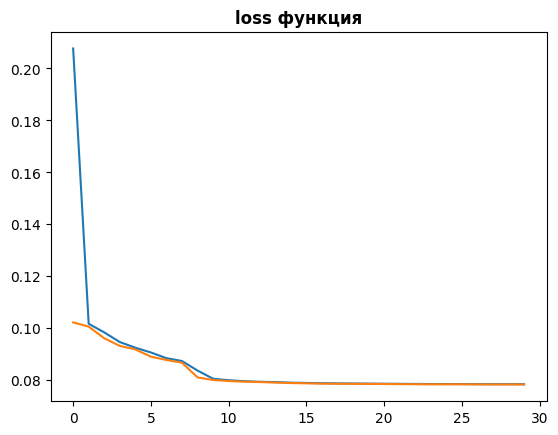

In [18]:
plt.plot(df_hist.loss)
plt.plot(df_hist.val_loss)
plt.title('loss функция', fontweight='bold')
plt.show()

In [19]:
test = np.load('/kaggle/input/sochi-light-data/y_smp_test.npy')
test

array([[[ 6.18020489, -1.60246727,  0.53633144],
        [-3.31159309,  1.34235087,  1.27781956],
        [ 1.13971284,  0.44974921,  1.22196404],
        ...,
        [ 0.65911036,  1.06125659,  1.10764883],
        [ 3.98138166, -0.30064017,  0.78664017],
        [-2.90192765,  1.51276899,  1.32060105]],

       [[ 0.78226124,  1.07162835,  1.29879078],
        [ 0.77731289,  0.6049763 ,  1.0738958 ],
        [-0.94206088,  0.70082783,  0.95289799],
        ...,
        [ 0.60972697,  0.31193782,  1.26403514],
        [ 0.01794818,  1.15206346,  1.53664382],
        [ 1.20711718,  0.44762037,  1.17774849]],

       [[ 0.42630142,  1.21500071,  2.5640936 ],
        [ 0.31149241,  0.81182898,  2.04631416],
        [-0.19228794, -0.09839751,  0.79582221],
        ...,
        [ 1.37422871,  1.92649191,  3.09302096],
        [ 0.29980895,  1.40371681,  2.77236719],
        [ 2.16341687,  2.7531414 ,  4.22434937]],

       ...,

       [[ 1.26574495,  2.03370887,  1.47314615],
        [ 2

In [20]:
test.shape

(100000, 200, 3)

In [21]:
pred = model.predict(test)
pred

3125/3125 [==============================] - 9s 3ms/step


array([[1.4182508 , 1.7841363 , 0.5099468 , ..., 0.0869195 , 0.0837485 ,
        0.09313954],
       [1.5212461 , 2.0817966 , 0.5019213 , ..., 0.08944373, 0.08814934,
        0.08208816],
       [1.5744774 , 2.1543255 , 0.4876149 , ..., 0.09062566, 0.09379043,
        0.09078844],
       ...,
       [1.5403256 , 2.0421753 , 0.48859563, ..., 0.08976837, 0.09288798,
        0.09683689],
       [1.4773995 , 1.9555893 , 0.5054017 , ..., 0.08836986, 0.08625461,
        0.08670241],
       [1.512562  , 1.9696038 , 0.49171695, ..., 0.08909968, 0.09138468,
        0.09845667]], dtype=float32)

In [22]:
pred.shape

(100000, 15)

In [23]:
np.save('test_cb_2.npy', pred)


In [ ]:
#получаем сохраненныу выше модель
model_load = tf.keras.models.load_model("/kaggle/input/sochi-light-data/model_cb_ver_1.h5")